# Problem Statement 
Can you create a model that will be able to differentiate posts from the subreddit r/TheOnion compared to posts from r/News? Having an entire subreddit with countless people on r/AteTheOnion, shows that either people are not checking their sources, tend to believe satirical news easily based on their own preconcieved notions/beliefs, or that satirical news are infact not being facetious but perhaps to close to being "real news" and in fact pose a bigger problem at spreading misinformation to people. By creating a model that can successfully tell the difference between the two subreddits, especially a model using a bag of words approach, will show whether or not people just believe what they want to, or if it actually is getting too hard to tell the difference between real and satirical news. 

#### It appears that when i re-ran my notebook, a good portion of posts that got scraped changed and affected my scores. The slides in the pdf present all the scores of my models before the change.   
> I now know when i scrape data might change I should probably export the df as a CSV and that in, in order to avoid having this happene again. 

**Here are what the models should have been**  
![](../imgs/Best_models.png)  



<span id='toc'></span>
## Table Of Content
---
1. **Normal starting point**
    1. [Imports](#imports)
    1. [Set up the API](#creds)
    1. [Scrapping data from TheOnion & News](#2nd_start)
    1. [Cleaning and EDA](#setup)
1. **Tesing models**
    1. [Baseline](#baseline)
    1. [CountVectorizer and quick tests](#cvec)
    1. [Pipe Line and GridSearch 1](#pipe1)
    1. [Making a df for scores](#scores)
    1. [TF-IDF](#tfidf1)
    1. [SVM Model tests](#svm)
    1. [Logistic Regression](#logreg)
    1. [Random Forest Classifier](#rfc)
1. **Experimentation for better models**
    1. [Combining and trying logreg](#mix1)
    1. [Mistake of running SVC GridSearch with many total fits](#a_mistake)
    1. [Checking how well upvotes work as a feature](#upvotes)
    1. [Using Sentiment Analysis on Title](#sentiment_anaylsis)
    1. [Why I didn't use some other models](#other_models)
    1. [Ensemble modeling our models](#enmod)
1. **Conclusions & Recommendations**
    1. [Conclusions](#conclusion)
    1. [Recommendations](#rec)
1. **Bonus**
    1. [See which headlines were misclassified](#bonus)

---
## Sources 
---

1. **PRAW** - Python Reddit API Wrapper
    1. [Praw Documentation](https://praw.readthedocs.io/en/stable/)
    1. [Youtube Tutorial](https://www.youtube.com/watch?v=8VZhog5C3bU&ab_channel=PythonEngineer)
1. **Reddit**
    1. [Reddit](https://reddit.com)
    1. [r/TheOnion](https://www.reddit.com/r/TheOnion/top/?t=all)
    1. [r/News](https://www.reddit.com/r/news/top/?t=all)
1. **Sklearn** as they ask to be cited on their website if published
    1. [Scikit-learn](https://scikit-learn.org/stable/auto_examples/index.html#classification) 

## Data Dictionary for the scrapping
Made using [this website](https://www.tablesgenerator.com/markdown_tables#)

| Column 	| Type 	| Description 	|
|:---:	|:---:	|:---:	|
| title_id 	| object 	| unique Id for the title of the post that can be used to check for comments if needed. 	|
| title 	| object 	| The title of the post submitted onto reddit.  	|
| upvotes 	| int 	| The number of upvotes the post received. 	|
| num_comments 	| int 	| The number of comments the post has. 	|
| author 	| object 	| The username or /u/ of the person who submitted the post onto reddit. 	|
| subreddit 	| object 	| The subreddit that the post was pulled from. 	|

<span id='imports'></span>
## Imports
___

In [1]:
# get stuff from reddit
import praw
import json

# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn models, prep, and metrics
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, plot_roc_curve, roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier

# for sentiment anaylsis
from transformers import pipeline

<span id='creds'></span>
## Get stuff from the credentials.json file to use reddit api
Information on how to do this was found in lesson 5.05
___

In [2]:
with open('../credentials.json') as credentials:    
    creds = json.load(credentials)

In [3]:
reddit = praw.Reddit(client_id = creds['client_id'],
                     client_secret = creds['client_secret'],
                     user_agent = creds['user_agent'])

<span id='2nd_start'></span>
## Pull information from r/onion vs r/news
> Originally was going to do r/AskReddi vs r/NoStupidQuestions, however, it was a bit too easy and without any exploring and with default values for CountVectorizer and Multinomial naive bayes, there was already a 99% accuracy score.  

[TOC](#toc)
___

#### We will use praw to get the 'title_id', 'title', 'upvotes', 'number of comments', and the 'subreddit'

In [4]:
# Lets get r/TheOnion first
onion_list = []
for submission in reddit.subreddit('theonion').top('year', limit=1000):
    headline = {}
    headline['title_id'] = submission.id
    headline['title'] = submission.title
    headline['upvotes'] = submission.score
    headline['num_comments'] = submission.num_comments
    headline['author'] = submission.author
    headline['subreddit'] = submission.subreddit

    onion_list.append(headline)
    
onion_df = pd.DataFrame(onion_list)
onion_df

,title_id,title,upvotes,num_comments,author,subreddit
0,p8ahzj,OnlyFans CEO Admits Decision To Ban Pornograph...,2970,40,ThatsMyPhoenix,TheOnion
1,o2zt6f,‘Loki’ Fan Loves How Show Contains So Many Ref...,2689,52,ThatsMyPhoenix,TheOnion
2,jdlpul,Spotify Celebrates 100th Dollar Given To Artists,2570,10,coolwali,TheOnion
3,jpcx4n,Media Condemns Biden For Baseless Claim That N...,2534,41,ThatsMyPhoenix,TheOnion
4,kjgmwj,"""Political Talk Show Host Suddenly Very Intere...",2526,14,mathis_01_08,TheOnion
...,...,...,...,...,...,...
994,obs7nx,Ford Introduces New Environmentally Friendly B...,17,0,9fmaverick,TheOnion
995,nuldt1,American Public Commended For Lasting 8 Rounds...,17,0,aresef,TheOnion
996,nrnp0r,Ron Artest Lands Consulting Role Teaching NBA ...,18,1,aresef,TheOnion
997,n7g5zk,FDA Delays Emergency Vaccine Approval Until Th...,15,0,caleb_1223,TheOnion


In [5]:
onion_df['title'][0]

'OnlyFans CEO Admits Decision To Ban Pornography Was Made In Shame-Filled Moment After Orgasm'

In [6]:
# Next up is r/News
news_list = []
for submission in reddit.subreddit('news').top('year', limit=1000):
    headline = {}
    headline['title_id'] = submission.id
    headline['title'] = submission.title
    headline['upvotes'] = submission.score
    headline['num_comments'] = submission.num_comments
    headline['author'] = submission.author
    headline['subreddit'] = submission.subreddit

    news_list.append(headline)
    
news_df = pd.DataFrame(news_list)
news_df

,title_id,title,upvotes,num_comments,author,subreddit
0,jptqj9,Joe Biden elected president of the United States,365121,28816,throwawaynumber53,news
1,mv0fzt,"Chauvin found guilty of murder, manslaughter i...",250008,28103,Too_Hood_95,news
2,l18yys,Trump has left the White House for the last ti...,222632,11810,gumball_Jones,news
3,jqfm3b,'Jeopardy' host Alex Trebek dies at 80 due to ...,200815,5411,Orange_fury,news
4,l1d2ko,Joe Biden officially sworn in as the 46th Pres...,176883,9102,douglasmacarthur,news
...,...,...,...,...,...,...
994,jiczco,"Californians see power shutoffs as winds, fire...",34241,2030,Express_Hyena,news
995,m17qkj,Deputies accused of sharing Kobe Bryant crash ...,34228,1282,ACABBLM2020,news
996,ld4k10,Jeffrey Epstein fund abruptly halts payouts to...,34178,1397,newnemo,news
997,m9qwx2,Pakistan: Two men sentenced to death for motor...,34173,2330,rainbowarriorhere,news


In [7]:
news_df['title'][1]

"Chauvin found guilty of murder, manslaughter in George Floyd's death"

> **Here we are just pulling in the top 1000 posts of the year from both subreddits, so we will have a total of 2000 rows in total when we combine them, with an equal ammount of information from each subreddit**

In [8]:
onion_df.dtypes

title_id        object
title           object
upvotes          int64
num_comments     int64
author          object
subreddit       object
dtype: object

<span id='setup'></span>
## Lets clean up the data frames to make them easier to work with  

[TOC](#toc)  
___

### Start by making the title_id the index

In [9]:
onion_df.set_index('title_id', inplace = True)
news_df.set_index('title_id', inplace = True)
onion_df

,title,upvotes,num_comments,author,subreddit
title_id,,,,,
p8ahzj,OnlyFans CEO Admits Decision To Ban Pornograph...,2970,40,ThatsMyPhoenix,TheOnion
o2zt6f,‘Loki’ Fan Loves How Show Contains So Many Ref...,2689,52,ThatsMyPhoenix,TheOnion
jdlpul,Spotify Celebrates 100th Dollar Given To Artists,2570,10,coolwali,TheOnion
jpcx4n,Media Condemns Biden For Baseless Claim That N...,2534,41,ThatsMyPhoenix,TheOnion
kjgmwj,"""Political Talk Show Host Suddenly Very Intere...",2526,14,mathis_01_08,TheOnion
...,...,...,...,...,...
obs7nx,Ford Introduces New Environmentally Friendly B...,17,0,9fmaverick,TheOnion
nuldt1,American Public Commended For Lasting 8 Rounds...,17,0,aresef,TheOnion
nrnp0r,Ron Artest Lands Consulting Role Teaching NBA ...,18,1,aresef,TheOnion


### Now we gotta combine the two df's into one big one with 2k rows

In [10]:
big_df = pd.concat([onion_df, news_df])
big_df

,title,upvotes,num_comments,author,subreddit
title_id,,,,,
p8ahzj,OnlyFans CEO Admits Decision To Ban Pornograph...,2970,40,ThatsMyPhoenix,TheOnion
o2zt6f,‘Loki’ Fan Loves How Show Contains So Many Ref...,2689,52,ThatsMyPhoenix,TheOnion
jdlpul,Spotify Celebrates 100th Dollar Given To Artists,2570,10,coolwali,TheOnion
jpcx4n,Media Condemns Biden For Baseless Claim That N...,2534,41,ThatsMyPhoenix,TheOnion
kjgmwj,"""Political Talk Show Host Suddenly Very Intere...",2526,14,mathis_01_08,TheOnion
...,...,...,...,...,...
jiczco,"Californians see power shutoffs as winds, fire...",34241,2030,Express_Hyena,news
m17qkj,Deputies accused of sharing Kobe Bryant crash ...,34228,1282,ACABBLM2020,news
ld4k10,Jeffrey Epstein fund abruptly halts payouts to...,34178,1397,newnemo,news


### Lets make the subreddits into 0 and 1. News will be 1 and onion will be 0

In [11]:
big_df['subreddit'] = [0 if sub == 'TheOnion' else 1 for sub in big_df['subreddit']]
big_df

,title,upvotes,num_comments,author,subreddit
title_id,,,,,
p8ahzj,OnlyFans CEO Admits Decision To Ban Pornograph...,2970,40,ThatsMyPhoenix,0
o2zt6f,‘Loki’ Fan Loves How Show Contains So Many Ref...,2689,52,ThatsMyPhoenix,0
jdlpul,Spotify Celebrates 100th Dollar Given To Artists,2570,10,coolwali,0
jpcx4n,Media Condemns Biden For Baseless Claim That N...,2534,41,ThatsMyPhoenix,0
kjgmwj,"""Political Talk Show Host Suddenly Very Intere...",2526,14,mathis_01_08,0
...,...,...,...,...,...
jiczco,"Californians see power shutoffs as winds, fire...",34241,2030,Express_Hyena,1
m17qkj,Deputies accused of sharing Kobe Bryant crash ...,34228,1282,ACABBLM2020,1
ld4k10,Jeffrey Epstein fund abruptly halts payouts to...,34178,1397,newnemo,1


> Originally I did want to use the map method instead of a list comprehension to do this, but for somereason, the .map() mehtod didn't seem to work that well making the values NaN even when the subreddits were copied and pasted by name making me think that the way the subreddits were passed in might have had some sort of issue interfering with the map

### As always lets just run a few checks first to make sure our data is good

In [12]:
big_df.isna().sum()

title            0
upvotes          0
num_comments     0
author          60
subreddit        0
dtype: int64

In [13]:
# Lets just get the first missing data and since this is on reddit, we can actually check instead of speculate
big_df[big_df['author'].isna()].iloc[0, 0]

'Report: 70% Of Republicans Believe Election Hasn’t Happened Yet'

> This author is na i'm assuming because the authors deleted their account.  
**it is**
![](../imgs/missing_authors.png)  

> **In this case, Because we have the title and subreddit, along with the number of of upvotes and comments We might be able to ignore the authors. Not only because there usually tend to be a select who almost always to a very few specific subreddits, it might make it too easy**

### While i'm here I might as well check to see if other than title upvotes can help determine a subreddit

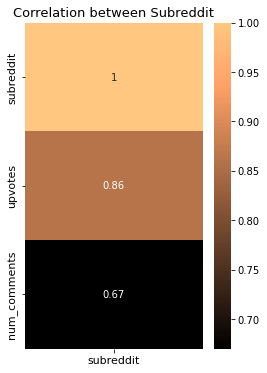

In [14]:
corr = big_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(4, 6))
sns.heatmap(corr[['subreddit']].sort_values(by = 'subreddit', ascending = False),
            annot = True,
            cmap = 'copper',
            vmin = 0.67,
            vmax = 1)

plt.yticks(size = 11)
plt.xticks(size = 11)
plt.title('Correlation between Subreddit', size = 13)


plt.show()

> We can also use upvote correlations to also help find what subreddit it belongs. It appears that upvotes does seem to have some correltion between the subreddits, possibly because of member difference leading to more views unless they get to the front page. Again, becauce this is all on reddit and public information we actually can check
>> **TheOnion:** 164k members  
>> **News:** 23.7 million members

### Lets go ahead and split our data now
Only the title for the moment and we can see how the other features might be used later on, if at all.

In [15]:
X = big_df['title']
y = big_df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1663)

### Lets just make sure we still got 50/50 split as we know that there is a an even ammount of information from both subreddits

In [16]:
print(f'Train:\n{y_train.value_counts(normalize=True)}')
print(f'Test:\n{y_test.value_counts(normalize=True)}')

Train:
0    0.5
1    0.5
Name: subreddit, dtype: float64
Test:
0    0.5
1    0.5
Name: subreddit, dtype: float64


<span id='baseline'></span>
# Establishing the BaseLine for test and goals

1. Because we have 1,000 posts from both subreddits (r/TheOnion and r/News) there is a 50/50 chance of correctly guess the subbredit given no information, therefore our **baseline score to beat is 50%**  
  
  
2. I am focusing more on accuracy for these model because it's a bit hard to say which is actually worse here. So going for specificty vs sensitivity is a hard choice and will therefor go with the default parameter of accuracy.
    * I say it's hard to choose one because one could argue for either side. It could be bad to recieve fake news and think it's true, especially if it's something crazy as TheOnion can sometimes get. Someone could act in a way they normally would not have and possibly ruin their life (if we're going to extremes here, but in both cases). On the flip side, we can have someone recieve real news that they would percieve as fake news and choose to ignore it, and then miss out on life changing opportunities, or possibly ruining their lives as well.

### Why I won't be using KNN in this notebook
While i did try KNN in my scratch-paper notebook, the results were so underwhelming and unhelpful I decided to not inlcude it into this final notebook. They would at best barely beat beat the baseline even when using gridsearch to look for the best hyperparameters

## Lets run a countvectorizer test<span id='cvec'></span>
[TOC](#toc)
___

In [17]:
cvec = CountVectorizer()
T_train = cvec.fit_transform(X_train) # T_train for transformized train
T_test = cvec.transform(X_test)
T_train

<1498x5663 sparse matrix of type '<class 'numpy.int64'>'
	with 18788 stored elements in Compressed Sparse Row format>

In [18]:
# Lets get a dataframe going and see what we have with countvect
T_train_df = pd.DataFrame(T_train.todense(),
                          columns = cvec.get_feature_names())
T_train_df.head()

,000,01,10,100,100k,109,10m,11,115,116,...,zack,zealand,zhao,zip,zone,zones,zookeepers,zoom,zorb,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 > To be honest, i'm a bit shocked at how small the bag of words we have actually, but a lot of these are just short one sentence summaries and there are only so many words

### Lets see how the defaults do first with the Multinomial Naive Bayes

In [19]:
bnb = BernoulliNB()
bnb.fit(T_train, y_train)
print('Train Score: ',bnb.score(T_train, y_train))
print('Test Score: ', bnb.score(T_test, y_test))

Train Score:  0.9719626168224299
Test Score:  0.874


In [20]:
## Lets also try the multinomial nb
mnb= MultinomialNB()
mnb.fit(T_train, y_train)
print('Train Score: ',mnb.score(T_train, y_train))
print('Test Score: ', mnb.score(T_test, y_test))

Train Score:  0.9739652870493992
Test Score:  0.87


 > it seems as though the Multinomial score is a bit better, but lets keep going and do some cross val scores to see where we actually are in terms of values as our variance for both are a bit high

In [21]:
# Check cross val of Multinomial Naive bayes
print('Training score: ',cross_val_score(MultinomialNB(), T_train, y_train).mean())
print('Testing Score: ', cross_val_score(MultinomialNB(), T_test, y_test).mean())

Training score:  0.8170903010033446
Testing Score:  0.786


In [22]:
# Lets do cross val of Bernoulli naive bayes
print('Training score: ',cross_val_score(BernoulliNB(), T_train, y_train).mean())
print('Testing Score: ', cross_val_score(BernoulliNB(), T_test, y_test).mean())

Training score:  0.8130903010033446
Testing Score:  0.792


> At least we are seeing similar and consistent results between the testing set in terms of bias and variance, however the multinomial seems to be doing a bit better, what if we try a pipeline and gridsearch for the best params

## Setting up a pipeline and gridsearch for the Multinomial Naive bayes<span id='pipe1'></span>
[TOC](#toc)
___

In [23]:
# Lets just make sure our X and y are all good to go in case we changed something above
X = big_df['title']
y = big_df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=14260)

In [24]:
mnb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

mbp_params = {'cvec__ngram_range':[(1,1), (1,2), (2,2)],
               'cvec__max_df': [0.90, 0.95, 1.0],
               'cvec__max_features': [2000, 3000, 4000, None],
               'cvec__min_df': [1, 2, 3, 4, 5],
               'cvec__stop_words':['english', None],
               'mnb__alpha': [0.5, 1, 2]}

In [25]:
mnb_gs = GridSearchCV(mnb_pipe,
                     mbp_params,
                     cv = 5,
                     verbose = 1)

mnb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95, 1.0],
                         'cvec__max_features': [2000, 3000, 4000, None],
                         'cvec__min_df': [1, 2, 3, 4, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english', None],
                         'mnb__alpha': [0.5, 1, 2]},
             verbose=1)

In [26]:
print(mnb_gs.best_params_)
mnb_gs.best_score_

{'cvec__max_df': 0.9, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'mnb__alpha': 1}


0.8351103678929765

> **I'm assuming it does better with the stop words included because these are news summaries, they will actually help in terms of which words will show up and be beneficial in terms of the few words per article**

In [27]:
mnb_gs.best_estimator_

Pipeline(steps=[('cvec', CountVectorizer(max_df=0.9)),
                ('mnb', MultinomialNB(alpha=1))])

In [28]:
print(mnb_gs.score(X_train, y_train))
print(mnb_gs.score(X_test, y_test))

0.9773030707610146
0.854


> One reason I the model might be struggling so hard with the testing set vs the training, is there are a lot of news from all around, and therefore will lead to words and phrases that didn't show up in the training set, but now show up in the testing set.

### Anyways, lets go ahead and make a confusion matrix of this just so we can see what our scores actually are.

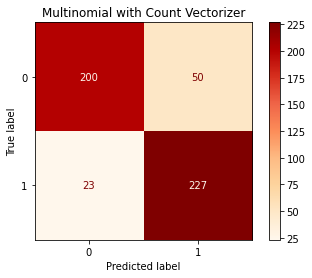

In [29]:
plot_confusion_matrix(mnb_gs, X_test, y_test, cmap ='OrRd');
plt.title('Multinomial with Count Vectorizer')

plt.show()

#### Lets also get all of our test scores, by hand to try to get used to the formulas and what they mean.

In [30]:
tn, fp, fn, tp = confusion_matrix(y_test, mnb_gs.predict(X_test)).ravel()

## Print out our scores
accuracy = (tp + tn) / (tp + tn + fp +fn)
misclass_rate = 1 - accuracy
sensitivity = tp/(tp + fn)
specificity = tn/(tn+fp)
percision = tp/ (tp+fp)

print('Accuracy:', accuracy)
print('Misclassification Rate:', misclass_rate)
print('Sensitivity', sensitivity)
print('Specifcity', specificity)
print('percision', percision)

Accuracy: 0.854
Misclassification Rate: 0.14600000000000002
Sensitivity 0.908
Specifcity 0.8
percision 0.8194945848375451


### Lets also generate an ROC-AUC to check how well distributed our models are 
This was taken from lesson 4.05, where "The ROC-AUC tells how much the model is capable of distinguishing between classes"

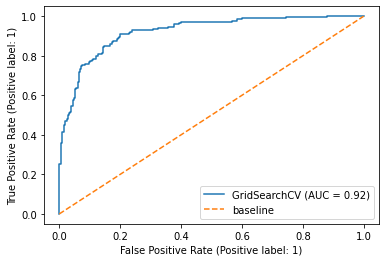

In [31]:
# from Lesson 4.05
# ROC curve
plot_roc_curve(mnb_gs, X_test, y_test);

# add worst case scenario line
plt.plot([0,1], [0,1],
        label = 'baseline',
        linestyle = '--')

# add a legend
plt.legend();

> It seems as though our model is at least fairly decent at telling apart real news from fake news. Being that 1 is the highest the AUC can be, the fact that we have a 0.93 means that while not perfect, our model does seem to have some sort of capability of differentiating between the two.

In [32]:
# Lets also check our F1 score while we're already here
f1_score(y_test, mnb_gs.predict(X_test))

0.8614800759013282

> In this case, our F1 score is a metric to test if we have low recall or preceision in which case we will have a lower score even if our accuracy is high. That way if we don't value accuracy but instead another metric it will be shown here. Because all our scores were around the same to each other though, our F1 managed to balance it self out to around what we had and wasen't greatly changed from the accuracy

## You know, lets start making a dataframe of what our scores are<span id='scores'>

In [33]:
result_df = pd.DataFrame(columns = ['best_params', 'training score', 'testing score'])
def add_info(model_name):
    holder = {}
    holder['best_params'] = model_name.best_params_
    holder['training score'] = model_name.score(X_train, y_train)
    holder['testing score'] = model_name.score(X_test, y_test)
    
    # lets actually also add some more information
    tn, fp, fn, tp = confusion_matrix(y_test, model_name.predict(X_test)).ravel()
    accuracy = (tp + tn) / (tp + tn + fp +fn)
    misclass_rate = 1 - accuracy
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn+fp)
    percision = tp/ (tp+fp)
    try:
        auc = roc_auc_score(y_test, model_name.predict_proba(X_test)[:,1])
    except:
        auc = 'No predict_prob'
    # add the scores into our dict
    # holder['Accuracy'] = accuracy (This is literally the same as the testing score as base metric is accuracy)
    holder['Misclassification Rate'] = misclass_rate
    holder['Sensitivity'] = sensitivity
    holder['Specifcity'] = specificity
    holder['percision'] = percision
    holder['AUC'] = auc

    return result_df.append((holder), ignore_index=True)

In [34]:
result_df = add_info(mnb_gs)
result_df

,best_params,training score,testing score,AUC,Misclassification Rate,Sensitivity,Specifcity,percision
0,"{'cvec__max_df': 0.9, 'cvec__max_features': No...",0.977303,0.854,0.922112,0.146,0.908,0.8,0.819495


In [35]:
result_df['best_params'][0]

{'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'mnb__alpha': 1}

> **The best_params look crowded, but i can always just check them invidiually I guess. Because I might add different paramemters for different model, I don't want to make a column for each one as there will be a lot of NaN's later on if I do decided to add them**

<span id ='tfidf1'></span>
## Time for a TF-IDF transformer and see if it works better than the countvect.
[TOC](#toc)

In [36]:
tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

tfidf_params = {'tfidf__ngram_range':[(1,1), (1,2), (2,2)],
               'tfidf__max_df': [0.90, 0.95, 1.0],
               'tfidf__max_features': [2000, 3000, 4000, None],
               'tfidf__min_df': [1, 2, 3, 4, 5],
               'tfidf__stop_words': ['english', None],
               'mnb__alpha': [0.5, 1, 2, 3]}

In [37]:
tfidf_gs = GridSearchCV(tfidf_pipe,
                     tfidf_params,
                     cv = 5,
                     verbose = 1)

tfidf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'mnb__alpha': [0.5, 1, 2, 3],
                         'tfidf__max_df': [0.9, 0.95, 1.0],
                         'tfidf__max_features': [2000, 3000, 4000, None],
                         'tfidf__min_df': [1, 2, 3, 4, 5],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tfidf__stop_words': ['english', None]},
             verbose=1)

In [38]:
tfidf_gs.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9, max_features=2000)),
                ('mnb', MultinomialNB(alpha=3))])

In [39]:
tfidf_gs.best_score_

0.8384503901895206

In [40]:
print(tfidf_gs.score(X_train, y_train))
print(tfidf_gs.score(X_test, y_test))

0.9345794392523364
0.822


### Confusion matrix and ROC-AUC time

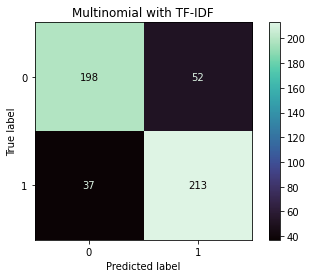

In [41]:
plot_confusion_matrix(tfidf_gs, X_test, y_test, cmap ='mako')
plt.title('Multinomial with TF-IDF')

plt.show()

In [42]:
tn, fp, fn, tp = confusion_matrix(y_test, tfidf_gs.predict(X_test)).ravel()

## Print out our scores
accuracy = (tp + tn) / (tp + tn + fp +fn)
misclass_rate = 1 - accuracy
sensitivity = tp/(tp + fn)
specificity = tn/(tn+fp)
percision = tp/ (tp+fp)

print('Accuracy:', accuracy)
print('Misclassification Rate:', misclass_rate)
print('Sensitivity', sensitivity)
print('Specifcity', specificity)
print('percision', percision)

Accuracy: 0.822
Misclassification Rate: 0.17800000000000005
Sensitivity 0.852
Specifcity 0.792
percision 0.8037735849056604


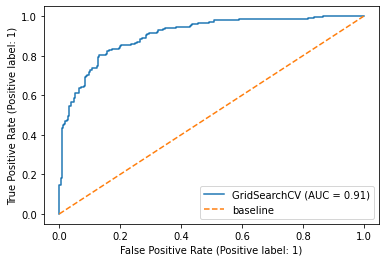

In [43]:
# from Lesson 4.05
# ROC curve
plot_roc_curve(tfidf_gs, X_test, y_test);

# add worst case scenario line
plt.plot([0,1], [0,1],
        label = 'baseline',
        linestyle = '--')

# add a legend
plt.legend();

> still running into similar problems here. Lets maybe try a different approach in improving our scores, treating these vectorized columns as dummy columns and adding them to the df

In [44]:
result_df = add_info(tfidf_gs)
result_df

,best_params,training score,testing score,AUC,Misclassification Rate,Sensitivity,Specifcity,percision
0,"{'cvec__max_df': 0.9, 'cvec__max_features': No...",0.977303,0.854,0.922112,0.146,0.908,0.800,0.819495
1,"{'mnb__alpha': 3, 'tfidf__max_df': 0.9, 'tfidf...",0.934579,0.822,0.905728,0.178,0.852,0.792,0.803774


<span id='svm'></span>
## Another Test I wanna try is the SVM ( Support Vector Machine ) model. 
This is a model this time instead of a transformer like before, but we might do it with both the transformers
[TOC](#toc)

In [45]:
# lets try the default values first
svmc = SVC()
cvec_svc = CountVectorizer()
X_train_svc = cvec_svc.fit_transform(X_train)
X_test_svc = cvec_svc.transform(X_test)
svmc.fit(X_train_svc, y_train)

SVC()

In [46]:
print(svmc.score(X_train_svc, y_train))
print(svmc.score(X_test_svc, y_test))

0.9913217623497997
0.81


### Lets try a pipe line for svc now, seems like the score isn't that bad

In [47]:
svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])

svc_params = {'tfidf__ngram_range':[(1,1), (1,2)],
               'tfidf__max_df': [0.90],
               'tfidf__max_features': [3000, None],
               'tfidf__min_df': [1, 2, 3],
               'svc__C': [0.01, 1],
               'svc__degree': [2, 3],
               'svc__kernel': ['poly','rbf'],
               'svc__probability': [True]}

svc_gs = GridSearchCV(svc_pipe,
                      svc_params,
                      cv = 5,
                      verbose = 1,
                      n_jobs = -1)

svc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.01, 1], 'svc__degree': [2, 3],
                         'svc__kernel': ['poly', 'rbf'],
                         'svc__probability': [True], 'tfidf__max_df': [0.9],
                         'tfidf__max_features': [3000, None],
                         'tfidf__min_df': [1, 2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [48]:
svc_gs.best_params_

{'svc__C': 1,
 'svc__degree': 2,
 'svc__kernel': 'poly',
 'svc__probability': True,
 'tfidf__max_df': 0.9,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1)}

In [49]:
print(svc_gs.score(X_train, y_train))
print(svc_gs.score(X_test, y_test))

0.9993324432576769
0.846


### Confusion Matrix and ROC-AUC time

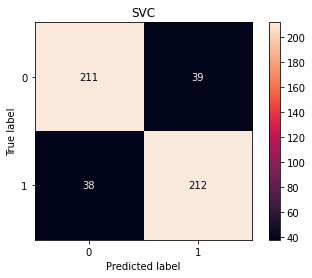

In [50]:
plot_confusion_matrix(svc_gs, X_test, y_test, cmap ='rocket')
plt.title('SVC')

plt.show()

In [51]:
tn, fp, fn, tp = confusion_matrix(y_test, svc_gs.predict(X_test)).ravel()

## Print out our scores
accuracy = (tp + tn) / (tp + tn + fp +fn)
misclass_rate = 1 - accuracy
sensitivity = tp/(tp + fn)
specificity = tn/(tn+fp)
percision = tp/ (tp+fp)

print('Accuracy:', accuracy)
print('Misclassification Rate:', misclass_rate)
print('Sensitivity', sensitivity)
print('Specifcity', specificity)
print('percision', percision)

Accuracy: 0.846
Misclassification Rate: 0.15400000000000003
Sensitivity 0.848
Specifcity 0.844
percision 0.8446215139442231


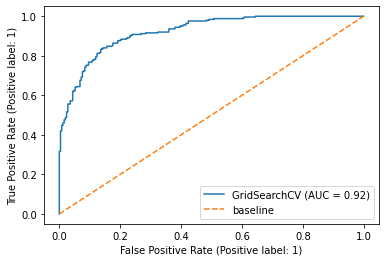

In [52]:
# from Lesson 4.05
# ROC curve
plot_roc_curve(svc_gs, X_test, y_test);

# add worst case scenario line
plt.plot([0,1], [0,1],
        label = 'baseline',
        linestyle = '--')

# add a legend
plt.legend();

In [53]:
# Add to our results
result_df = add_info(svc_gs)
result_df

,best_params,training score,testing score,AUC,Misclassification Rate,Sensitivity,Specifcity,percision
0,"{'cvec__max_df': 0.9, 'cvec__max_features': No...",0.977303,0.854,0.922112,0.146,0.908,0.800,0.819495
1,"{'mnb__alpha': 3, 'tfidf__max_df': 0.9, 'tfidf...",0.934579,0.822,0.905728,0.178,0.852,0.792,0.803774
2,"{'svc__C': 1, 'svc__degree': 2, 'svc__kernel':...",0.999332,0.846,0.921848,0.154,0.848,0.844,0.844622


<span id ='logreg'></span>
## What about a Logistic Regression?
[TOC](#toc)

In [54]:
log_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                     ('lr', LogisticRegression())])

log_params = {'tfidf__ngram_range':[(1,1), (1,2), (1,3)],
               'tfidf__max_df': [0.90, 0.95, 1.0],
               'tfidf__max_features': [2000, 3000, None],
               'tfidf__min_df': [1, 2, 3, 4, 5],
               'lr__C' : [0.5, 1, 2, 3],
               'lr__penalty': ['l1', 'l2'],
               'lr__solver': ['liblinear']}

log_gs = GridSearchCV(log_pipe,
                      log_params,
                      cv = 5,
                      verbose = 1,
                      n_jobs=8)

log_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=8,
             param_grid={'lr__C': [0.5, 1, 2, 3], 'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['liblinear'],
                         'tfidf__max_df': [0.9, 0.95, 1.0],
                         'tfidf__max_features': [2000, 3000, None],
                         'tfidf__min_df': [1, 2, 3, 4, 5],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

In [55]:
print(log_gs.best_score_)
log_gs.best_params_

0.836448160535117


{'lr__C': 2,
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear',
 'tfidf__max_df': 0.9,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2)}

In [56]:
print(log_gs.score(X_train, y_train))
print(log_gs.score(X_test, y_test))

0.9986648865153538
0.832


In [57]:
result_df = add_info(log_gs)
result_df

,best_params,training score,testing score,AUC,Misclassification Rate,Sensitivity,Specifcity,percision
0,"{'cvec__max_df': 0.9, 'cvec__max_features': No...",0.977303,0.854,0.922112,0.146,0.908,0.800,0.819495
1,"{'mnb__alpha': 3, 'tfidf__max_df': 0.9, 'tfidf...",0.934579,0.822,0.905728,0.178,0.852,0.792,0.803774
2,"{'svc__C': 1, 'svc__degree': 2, 'svc__kernel':...",0.999332,0.846,0.921848,0.154,0.848,0.844,0.844622
3,"{'lr__C': 2, 'lr__penalty': 'l2', 'lr__solver'...",0.998665,0.832,0.906544,0.168,0.840,0.824,0.826772


Text(0.5, 1.0, 'Logistic Regression')

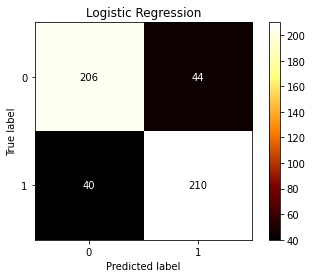

In [58]:
plot_confusion_matrix(log_gs, X_test, y_test, cmap ='afmhot')
plt.title('Logistic Regression')

In [59]:
tn, fp, fn, tp = confusion_matrix(y_test, log_gs.predict(X_test)).ravel()

## Print out our scores
accuracy = (tp + tn) / (tp + tn + fp +fn)
misclass_rate = 1 - accuracy
sensitivity = tp/(tp + fn)
specificity = tn/(tn+fp)
percision = tp/ (tp+fp)

print('Accuracy:', accuracy)
print('Misclassification Rate:', misclass_rate)
print('Sensitivity', sensitivity)
print('Specifcity', specificity)
print('percision', percision)

Accuracy: 0.832
Misclassification Rate: 0.16800000000000004
Sensitivity 0.84
Specifcity 0.824
percision 0.8267716535433071


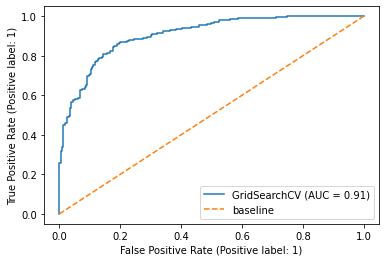

In [60]:
# from Lesson 4.05
# ROC curve
plot_roc_curve(log_gs, X_test, y_test);

# add worst case scenario line
plt.plot([0,1], [0,1],
        label = 'baseline',
        linestyle = '--')

# add a legend
plt.legend();

<span id='rfc'></span>
## Random Forest Classifier
[TOC](#toc)

In [61]:
## First things first, lets see get a baseline with the defualt params, which will probably be overfit, as well cvs
tfidf_1 = TfidfVectorizer()
X_train_tf = tfidf_1.fit_transform(X_train)
X_test_tf = tfidf_1.transform(X_test)


rf = RandomForestClassifier()
rf.fit(X_train_tf, y_train)

print(f'Training score: {rf.score(X_train_tf, y_train)}')
print(f'Testing score: {rf.score(X_test_tf, y_test)}')

Training score: 1.0
Testing score: 0.762


> this actually isnt too bad for default parameters, but now lets do a pipeline to try to optomize things here

In [62]:
# Time to make a pipeline

# a normal tfidf vectorizer seems to work better than countvect and tfidf transformer 
rf_pipe = Pipeline([ ('tfidf', TfidfVectorizer()),
                     ('rf', RandomForestClassifier())])

rf_params = {'tfidf__ngram_range':[(1,2)],
             'tfidf__max_df': [0.90],
             'rf__n_estimators': [200, 250, 300],
             'rf__max_depth': [50, 100, 150],
             'rf__min_samples_split' : [7, 8],
             'rf__max_features': ['auto', 'log2'],
             'rf__min_samples_leaf': [1, 2],
             'rf__ccp_alpha' : [1e-07, 1e-08]}

rf_gs = GridSearchCV(rf_pipe,
                     rf_params,
                     cv = 5,
                     verbose = 1,
                     n_jobs = 8)

rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=8,
             param_grid={'rf__ccp_alpha': [1e-07, 1e-08],
                         'rf__max_depth': [50, 100, 150],
                         'rf__max_features': ['auto', 'log2'],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [7, 8],
                         'rf__n_estimators': [200, 250, 300],
                         'tfidf__max_df': [0.9],
                         'tfidf__ngram_range': [(1, 2)]},
             verbose=1)

In [63]:
rf_gs.best_params_

{'rf__ccp_alpha': 1e-08,
 'rf__max_depth': 100,
 'rf__max_features': 'log2',
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 8,
 'rf__n_estimators': 250,
 'tfidf__max_df': 0.9,
 'tfidf__ngram_range': (1, 2)}

In [64]:
print(rf_gs.score(X_train, y_train))
print(rf_gs.score(X_test, y_test))

0.9946595460614153
0.82


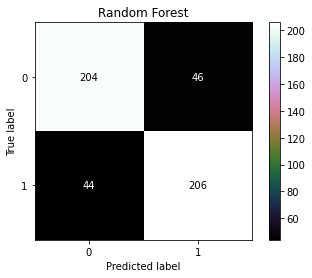

In [65]:
plot_confusion_matrix(rf_gs, X_test, y_test, cmap ='cubehelix')
plt.title('Random Forest')

plt.show()

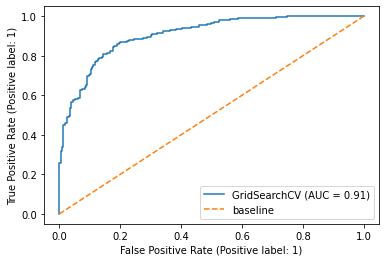

In [66]:
# from Lesson 4.05
# ROC curve
plot_roc_curve(log_gs, X_test, y_test);

# add worst case scenario line
plt.plot([0,1], [0,1],
        label = 'baseline',
        linestyle = '--')

# add a legend
plt.legend();

In [67]:
result_df = add_info(rf_gs)
result_df

,best_params,training score,testing score,AUC,Misclassification Rate,Sensitivity,Specifcity,percision
0,"{'cvec__max_df': 0.9, 'cvec__max_features': No...",0.977303,0.854,0.922112,0.146,0.908,0.800,0.819495
1,"{'mnb__alpha': 3, 'tfidf__max_df': 0.9, 'tfidf...",0.934579,0.822,0.905728,0.178,0.852,0.792,0.803774
2,"{'svc__C': 1, 'svc__degree': 2, 'svc__kernel':...",0.999332,0.846,0.921848,0.154,0.848,0.844,0.844622
3,"{'lr__C': 2, 'lr__penalty': 'l2', 'lr__solver'...",0.998665,0.832,0.906544,0.168,0.840,0.824,0.826772
4,"{'rf__ccp_alpha': 1e-08, 'rf__max_depth': 100,...",0.994660,0.820,0.895728,0.180,0.824,0.816,0.817460


<span id ='mix1'></span>
## Let's try something we haven't learned if we can do or not, but with logistic regression or svm, it might be possible to combine the basically dummified version of the title along with number of comments and number of upvotes. <span id ='mix1'></span>
[TOC](#toc)

In [68]:
## Our X_train and X_test are still okay to be transformed right now, lets make a df out of it
# lets go basic with countvect first to see what we get before making a whole pipeline for it
cvec_2 = CountVectorizer(max_df=0.9, ngram_range=(1,2))  
X_train_cvec = cvec_2.fit_transform(X_train, y_train)
X_test_cvec = cvec_2.transform(X_test)


# Turn our transformed X_train and X_test into dataframes as thats what will be needed
X_train_df = pd.DataFrame(X_train_cvec.todense(),
                         columns = cvec_2.get_feature_names(),
                         index = X_train.index)
X_test_df = pd.DataFrame(X_test_cvec.todense(),
                         columns = cvec_2.get_feature_names(),
                        index = X_test.index)

# Make sure they have the same number of columns
print(X_train_df.shape)
print(X_test_df.shape)

(1498, 20713)
(500, 20713)


In [69]:
# Lets just check the train_df to make sure the index is there as we will combine using indicies
X_train_df.head(3)

,000,000 acres,000 beds,000 covid,000 deaths,000 each,000 earned,000 electric,000 employees,000 friends,...,zones,zones out,zookeepers,zookeepers confirm,zoom,zoom shared,zoom will,zorb,zz,zz top
title_id,,,,,,,,,,,,,,,,,,,,,
m7zo4g,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
or7x1k,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
oou7kh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
X_train_mix = pd.merge(big_df[['num_comments', 'upvotes']], X_train_df, left_index = True, right_index=True)
X_test_mix = pd.merge(big_df[['num_comments', 'upvotes']], X_test_df, left_index = True, right_index=True)
X_test_mix.head()

,num_comments,upvotes,000,000 acres,000 beds,000 covid,000 deaths,000 each,000 earned,000 electric,...,zones,zones out,zookeepers,zookeepers confirm,zoom,zoom shared,zoom will,zorb,zz,zz top
title_id,,,,,,,,,,,,,,,,,,,,,
kjgmwj,14,2526,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
p0zhkl,25,2398,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ks1tm5,23,2383,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kl9gh4,77,2264,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
k1kuff,23,2066,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
## Time to scale it as we have multiple scales now and use logistic Regression
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_mix)
X_test_sc = sc.transform(X_test_mix)

## Lets now lets try a logistic_reg
lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train_sc, y_train)
print(lr.score(X_train_sc, y_train))
print(lr.score(X_test_sc, y_test))

0.9899866488651535
0.494


> okay, what happened here. Why is the testing score so low. This is 100% a very overfit model. I guess thats why the naive bayes is of importance when dealing with these as they will "assume" indepence of words when there actually isn't. Lets scrap the idea of using it all at once, maybe we can do seperate model and then incorporate their probability to help one another.

<span id='cvec+tfidf'></span>
## Imma try something weird here, what if I try running countvect first then TF-IDF in a pipeline?
**I know they're similar, tf-idf is like an upgraded version of it, but what if the double check can help my accuracy?**  
[TOC](#toc)

In [72]:
# Lets just make sure our X_train hasen't been transformed accidentally or had something happen to it
X_train[:3]

title_id
m7zo4g    Biden orders US flags flown at half-staff afte...
or7x1k    German TV reporter fired after caught smearing...
oou7kh    Man found dead with ‘I touch little girls’ wri...
Name: title, dtype: object

In [73]:
# lets start by making a new pipeline with similar params as before 
combo_pipe = Pipeline([('cvec', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('mnb', MultinomialNB())])

combo_params = {'cvec__ngram_range':[(1,1), (1,2), (2,2)],
                'cvec__max_df': [0.90, 0.95, 1.0],
                'cvec__max_features': [2000, 3000, 4000, None],
                'cvec__min_df': [1, 2, 3, 4, 5],
                'tfidf__use_idf': [True, False],
                'tfidf__norm': ['l1', 'l2'],
                'tfidf__smooth_idf': [True, False]}

> Had to use a transformer instead of vectorizer for TF-IDF because I kept getting an error till I checked [this website](https://www.titanwolf.org/Network/q/f9fc5f00-9aef-4178-8c1b-653d26ad9832/y) that said to use the transformer instead of vec when having a double transformation

In [74]:
# Now lets make a grid for this pipeline 
combo_gs = GridSearchCV(combo_pipe,
                        combo_params,
                        cv = 5,
                        verbose = 1)

combo_gs.fit(list(X_train), y_train) 
# using a list because without it said it needed a list passed instead of what I had

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95, 1.0],
                         'cvec__max_features': [2000, 3000, 4000, None],
                         'cvec__min_df': [1, 2, 3, 4, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__smooth_idf': [True, False],
                         'tfidf__use_idf': [True, False]},
             verbose=1)

In [75]:
print(combo_gs.best_score_)
combo_gs.best_params_

0.8417904124860647


{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'tfidf__norm': 'l1',
 'tfidf__smooth_idf': False,
 'tfidf__use_idf': True}

In [76]:
print(combo_gs.score(X_train, y_train))
print(combo_gs.score(X_test, y_test))

0.9385847797062751
0.82


In [77]:
# Lets add this into our df I guess, but not too happy with the scores, but at least they went up
result_df = add_info(combo_gs)
result_df

,best_params,training score,testing score,AUC,Misclassification Rate,Sensitivity,Specifcity,percision
0,"{'cvec__max_df': 0.9, 'cvec__max_features': No...",0.977303,0.854,0.922112,0.146,0.908,0.800,0.819495
1,"{'mnb__alpha': 3, 'tfidf__max_df': 0.9, 'tfidf...",0.934579,0.822,0.905728,0.178,0.852,0.792,0.803774
2,"{'svc__C': 1, 'svc__degree': 2, 'svc__kernel':...",0.999332,0.846,0.921848,0.154,0.848,0.844,0.844622
3,"{'lr__C': 2, 'lr__penalty': 'l2', 'lr__solver'...",0.998665,0.832,0.906544,0.168,0.840,0.824,0.826772
4,"{'rf__ccp_alpha': 1e-08, 'rf__max_depth': 100,...",0.994660,0.820,0.895728,0.180,0.824,0.816,0.817460
5,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.938585,0.820,0.903232,0.180,0.828,0.812,0.814961


Text(0.5, 1.0, 'CountVect & TF-IDF')

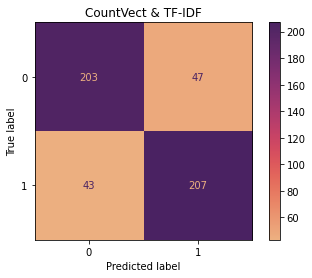

In [78]:
plot_confusion_matrix(combo_gs, X_test, y_test, cmap ='flare')
plt.title('CountVect & TF-IDF')

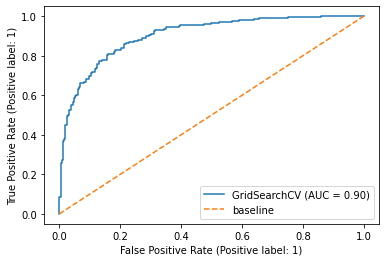

In [79]:
# ROC curve
plot_roc_curve(combo_gs, X_test, y_test);

# add worst case scenario line
plt.plot([0,1], [0,1],
        label = 'baseline',
        linestyle = '--')

# add a legend
plt.legend();

<span id ='a_mistake'></span>
## This took over 20 minutes to run so i will be commenting it out and not running it agian.
[TOC](#toc)

``` python
# lets start by making a new pipeline with similar params as before 
combo_pipe_2 = Pipeline([('cvec', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('svm', SVC())])

combo_params_2 = {'cvec__ngram_range':[(1,1), (1,2), (2,2)],
                'cvec__max_df': [0.90, 0.95, 1.0],
                'cvec__max_features': [2000, 3000, 4000, None],
                'cvec__min_df': [1, 2, 3, 4, 5],
                'tfidf__use_idf': [True, False],
                'tfidf__norm': ['l1', 'l2'],
                'tfidf__smooth_idf': [True, False]}
```
---

---
``` python
# Now lets make a grid for this pipeline 
combo_gs = GridSearchCV(combo_pipe_2,
                        combo_params_2,
                        cv = 5,
                        verbose = 1)

combo_gs.fit(list(X_train), y_train)
```
**OUTPUT**
```
GridSearchCV(cv=5,  
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),  
                                       ('tfidf', TfidfTransformer()),  
                                       ('svm', SVC())]),  
             param_grid={'cvec__max_df': [0.9, 0.95, 1.0],  
                         'cvec__max_features': [2000, 3000, 4000, None],  
                         'cvec__min_df': [1, 2, 3, 4, 5],  
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],  
                         'tfidf__norm': ['l1', 'l2'],  
                         'tfidf__smooth_idf': [True, False],  
                         'tfidf__use_idf': [True, False]},  
             verbose=1)
```
---

``` python
print(combo_gs.score(X_train, y_train))
print(combo_gs.score(X_test, y_test))
``` 
    1.0  
    0.83

> anyways, it was similar to the original SVC test from before

<span id ='upvotes'></span>
## Before getting to try newer models, lets just check how well a model with the number of upvotes does to see if we can use that as a model to combine with another successful model  
[TOC](#toc)

In [80]:
X_upvotes = big_df[['upvotes']]
y_upvotes = big_df['subreddit']

X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_upvotes, y_upvotes, stratify=y, random_state = 3)

In [81]:
# make the logreg model
lr = LogisticRegression()
lr.fit(X_train_up, y_train_up)

print(lr.score(X_train_up, y_train_up))
print(lr.score(X_test_up, y_test_up))

1.0
1.0


> Hmm. Is this because there is such a big difference in viewer base per subreddit? because lets not forget the gap  
> **TheOnion:** 164k members  
> **News:**     23.7 million members

In [82]:
# Lets do one more check 
cross_val_score(LogisticRegression(), X_upvotes, y_upvotes)

array([1., 1., 1., 1., 1.])

### Lets take a look at the distribution of them to see if maybe the answer about this will be more apparent

Text(0.5, 1.0, 'Upvotes vs Subreddit')

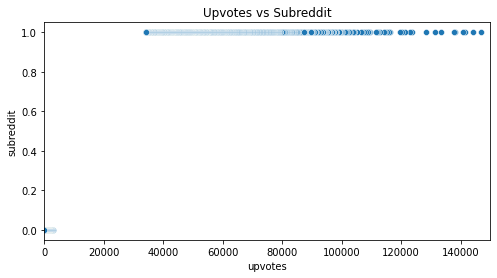

In [83]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x = X_upvotes['upvotes'], y = y);

plt.axis([0, 150000, -0.05, 1.05]);
plt.title('Upvotes vs Subreddit', size = 12)

> Yeah this makes sense. There is no onion post with more than the least upvoted news post.  
  
> Because this will give us a perfect model, lets also not include the number of upvotes and number of comments

<span id = 'sentiment_anaylsis'></span>
## Okay, so we can't use the numeric columns for number of upvotes, or comments, but what if we still try to use two different types of model, the 2nd one being a sentient analysis, so we go through each column and decide where it belongs that way
Taken from lessons 5.06 for how to install and use it  
[TOC](#toc)

In [84]:
# Instantiate the sentiment-analysis using the hugging-face transformer pipeline
sent = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [85]:
# Lets just make sure it works
print(sent('I am good'))
print(sent('I am bad'))
print(sent('Love it'))
print(sent('Hate it'))

[{'label': 'POSITIVE', 'score': 0.999847412109375}]
[{'label': 'NEGATIVE', 'score': 0.9998001456260681}]
[{'label': 'POSITIVE', 'score': 0.9998753070831299}]
[{'label': 'NEGATIVE', 'score': 0.9997389912605286}]


### Running a loop to get a list of dictionary to make a dataframe from the results

In [86]:
train_sens = []
for x in X:
    dict_hold = {}
    dict_hold['label'] = sent(x)[0]['label']
    dict_hold['score'] = sent(x)[0]['score']
    
    train_sens.append(dict_hold)
    
sent_df = pd.DataFrame(train_sens)
sent_df

,label,score
0,NEGATIVE,0.983922
1,POSITIVE,0.987925
2,POSITIVE,0.998012
3,NEGATIVE,0.996081
4,POSITIVE,0.806375
...,...,...
1993,NEGATIVE,0.987961
1994,NEGATIVE,0.993715
1995,NEGATIVE,0.999641
1996,NEGATIVE,0.990542


In [87]:
## lets also change the lables for 1 for positive and 0 for negative
sent_df['label'] = sent_df['label'].map({'NEGATIVE': 0, 'POSITIVE':1})
sent_df

,label,score
0,0,0.983922
1,1,0.987925
2,1,0.998012
3,0,0.996081
4,1,0.806375
...,...,...
1993,0,0.987961
1994,0,0.993715
1995,0,0.999641
1996,0,0.990542


In [88]:
# Lets add the target values now
sent_df['subreddit'] = y.values
sent_df

,label,score,subreddit
0,0,0.983922,0
1,1,0.987925,0
2,1,0.998012,0
3,0,0.996081,0
4,1,0.806375,0
...,...,...,...
1993,0,0.987961,1
1994,0,0.993715,1
1995,0,0.999641,1
1996,0,0.990542,1


### Because there are only numbers 0.5 - 1 based on positive and negative, lets make the negative their score, but going the other way. So the closer to 0 they are, the more negative

In [89]:
neg_scores_index = sent_df[sent_df['label'] == 0].index

for index in neg_scores_index:
    sent_df['score'][index] = 1-sent_df['score'][index]
    
sent_df

C:\Users\16615\AppData\Local\Temp/ipykernel_10792/331087675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_df['score'][index] = 1-sent_df['score'][index]


,label,score,subreddit
0,0,0.016078,0
1,1,0.987925,0
2,1,0.998012,0
3,0,0.003919,0
4,1,0.806375,0
...,...,...,...
1993,0,0.012039,1
1994,0,0.006285,1
1995,0,0.000359,1
1996,0,0.009458,1


In [90]:
# Lets get to predicting now
X_sent = sent_df[['label','score']]
y_sent = sent_df['subreddit']

Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_sent, y_sent, stratify=y, random_state=42)

In [91]:
# since both the x's are on a scale of 0 - 1, i don't think i need to standard scale this
lr = LogisticRegression() # lets just try default values first to see if its even worth pursing logreg with gridsearch
lr.fit(Xs_train, ys_train)

print(lr.score(Xs_train, ys_train))
print(lr.score(Xs_test, ys_test))

0.5554072096128171
0.576


> The scores are suspiciously close the to the baseline making me believe that they are fairly well split between each subreddit.

In [92]:
sent_df['label'] = ['Negative' if num == 0 else 'Positive' for num in sent_df['label']]

In [93]:
sent_df

,label,score,subreddit
0,Negative,0.016078,0
1,Positive,0.987925,0
2,Positive,0.998012,0
3,Negative,0.003919,0
4,Positive,0.806375,0
...,...,...,...
1993,Negative,0.012039,1
1994,Negative,0.006285,1
1995,Negative,0.000359,1
1996,Negative,0.009458,1


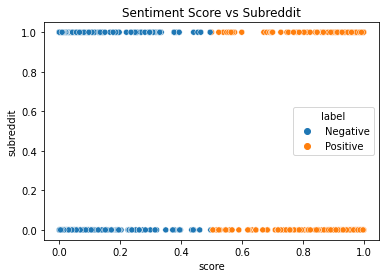

In [94]:
# now we just need to graph score vs subreddit to see how it actually looks
sns.scatterplot(x = sent_df['score'], y = sent_df['subreddit'], hue = sent_df['label']);
plt.title('Sentiment Score vs Subreddit');

> This explains the the logistic regression slightly more than 50% model. The sensitivity scores are fairly well split, except for some small portions (like y = 1 @ 0.7).  
**The hue was just added to make sure I split the negative and positive scores properly**  
  
> Sensitivity will just be another factor we won't be able to use. However, as is our model is performing decently.

<span id='other_models'></span>
## Some models not included in this notebook.
In my scratch paper notebook I also attemped to test the Gaussian and Bernulli Naive bayes a bit more in depth, but after looking up what they are actually used for concluded it doesn't make sense to include them in the final notebook. An example of the Bernulli in this notebook is found [here](#cvec). Because I don't care as much about the abscense of a particular word in the document, as I do for finding relevant key words that can be used to classify (therefore just more words in general to have a bigger collection) I decided to stick with the multinomial nb.   
  
For the Gaussian model, it tends to work better on continous data because it uses the assumption of a normal distribution and therefor wouldn't even be too helpful in our case of BOW. I did manage to get it to work, but the model was very overfit, as well as running into issues when trying to create a pipeline. I will inlucde some work I used for it though  
[TOC](#toc)

``` python
cvec_3 = CountVectorizer() # default params first just to see what this is about
X_train_cv = cvec_3.fit_transform(X_train)
X_test_cv = cvec_3.transform(X_test)


gnb = GaussianNB() # lets try default params first
gnb.fit(X_train_cv.toarray(), y_train)

print(gnb.score(X_train_cv.todense(), y_train))
print(gnb.score(X_test_cv.todense(), y_test))
```
[Output]  
0.9913333333333333  
0.748
____

``` python
gnb_pipeline = Pipeline([('cvec', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('gnb', GaussianNB())])

gnb_params = {'cvec__ngram_range':[(1,1), (1,2), (2,2)],
                'cvec__max_df': [0.90, 0.95, 1.0],
                'cvec__max_features': [2000, 3000, 4000, None],
                'cvec__min_df': [1, 2, 3, 4, 5],
                'tfidf__use_idf': [True, False],
                'tfidf__norm': ['l1', 'l2'],
                'tfidf__smooth_idf': [True, False]}

gnb_gs = GridSearchCV(gnb_pipeline,
                      gnb_params,
                      cv = 5,
                      verbose = 1)

gnb_gs.fit(X_train, y_train)
```

And when trying to figure out how to get my pipeline to work with the Gaussian model, I came across this piece of advice from [github](https://github.com/scikit-learn/scikit-learn/issues/6440)
![](../imgs/no_gaus.png)

<span id='enmod'></span>
## One last attempt at trying to get a better accuracy score. We will combine the predictions of the top 5 models and average them.
#### Idea of combing the scores and making the dataframe and all was taking lesson 6.02

Because we used the same test split for all of the models, (never altering the original split with a random state), the order of the X_test and y_test values should be the same and we can therefor make a dataframe of the result, however, just in case we should add them by the title_index  
[TOC](#toc)

In [95]:
# make a list of the models to iter through
model_list = [mnb_gs, tfidf_gs, svc_gs, rf_gs, combo_gs]

# new dateframe that will only hold the predictions
train_models_preds_df = pd.DataFrame(index = X_train.index)

for i in range(len(model_list)):
    train_models_preds_df[f'Train_Model_{i}'] = model_list[i].predict(X_train)
    
train_models_preds_df.head()

,Train_Model_0,Train_Model_1,Train_Model_2,Train_Model_3,Train_Model_4
title_id,,,,,
m7zo4g,1,1,1,1,1
or7x1k,1,1,1,1,1
oou7kh,1,1,1,1,1
prg0kg,0,0,0,0,0
jshht6,0,0,0,0,0


In [96]:
# make a list of the models to iter through
model_list = [mnb_gs, tfidf_gs, svc_gs, rf_gs, combo_gs]

# new dateframe that will only hold the predictions
test_models_preds_df = pd.DataFrame(index = X_test.index)

for i in range(len(model_list)):
    test_models_preds_df[f'Test_Model_{i}'] = model_list[i].predict(X_test)
    
test_models_preds_df.head()

,Test_Model_0,Test_Model_1,Test_Model_2,Test_Model_3,Test_Model_4
title_id,,,,,
k6wkgk,0,1,0,0,1
mcc3gr,1,0,1,0,0
k3elf4,0,0,0,0,0
lkbf2k,1,0,1,0,0
m17qkj,1,1,1,1,1


> hmm, doesn't look like there is too much variation, but we do know they have different scores, but lets see how well this actually does

In [97]:
train_models_preds_df['predictions'] = train_models_preds_df.mean(axis = 1)
train_models_preds_df

,Train_Model_0,Train_Model_1,Train_Model_2,Train_Model_3,Train_Model_4,predictions
title_id,,,,,,
m7zo4g,1,1,1,1,1,1.0
or7x1k,1,1,1,1,1,1.0
oou7kh,1,1,1,1,1,1.0
prg0kg,0,0,0,0,0,0.0
jshht6,0,0,0,0,0,0.0
...,...,...,...,...,...,...
o9vkjm,1,1,1,1,1,1.0
m0zfm7,0,0,0,0,0,0.0
m9f606,1,1,1,1,1,1.0


In [98]:
test_models_preds_df['predictions'] = test_models_preds_df.mean(axis = 1)
test_models_preds_df

,Test_Model_0,Test_Model_1,Test_Model_2,Test_Model_3,Test_Model_4,predictions
title_id,,,,,,
k6wkgk,0,1,0,0,1,0.4
mcc3gr,1,0,1,0,0,0.4
k3elf4,0,0,0,0,0,0.0
lkbf2k,1,0,1,0,0,0.4
m17qkj,1,1,1,1,1,1.0
...,...,...,...,...,...,...
md0h9w,1,1,0,0,0,0.4
p8asey,0,0,0,0,0,0.0
pdzs6c,0,0,0,0,0,0.0


In [99]:
# now lets say that if predictions is less than 0.5 it will be 0 and more will be a 1
# because we have 5 models we don't have to worry about a mean of exactly 0.5

train_models_preds_df['predictions'] = (train_models_preds_df['predictions'] > 0.5) * 1
test_models_preds_df['predictions'] = (test_models_preds_df['predictions'] > 0.5) * 1

# make sure the sum is a whole number
print(train_models_preds_df['predictions'].sum())
print(test_models_preds_df['predictions'].sum())

764
261


In [100]:
print(f"Training accuracy: {accuracy_score(y_train, train_models_preds_df['predictions'])}")
print(f"Testing accuracy: {accuracy_score(y_test, test_models_preds_df['predictions'])}")

Training accuracy: 0.9739652870493992
Testing accuracy: 0.842


> By averaging the score of all 5 models we decided to keep, we actually managed to get a better accuracy score! Although only by a bit, the score is higher than any one of the models we actually used. We can actually also do some calculations to get our scores and add them to the result dataframe!

In [101]:
tn, fp, fn, tp = confusion_matrix(y_test, test_models_preds_df['predictions']).ravel()

## Print out our scores
accuracy = (tp + tn) / (tp + tn + fp +fn)
misclass_rate = 1 - accuracy
sensitivity = tp/(tp + fn)
specificity = tn/(tn+fp)
percision = tp/ (tp+fp)

print('Accuracy:', accuracy)
print('Misclassification Rate:', misclass_rate)
print('Sensitivity', sensitivity)
print('Specifcity', specificity)
print('percision', percision)

Accuracy: 0.842
Misclassification Rate: 0.15800000000000003
Sensitivity 0.864
Specifcity 0.82
percision 0.8275862068965517


In [102]:
add_result = {'best_params': 'All of them',
              'training score': accuracy_score(y_train, train_models_preds_df['predictions']),
              'testing score': accuracy_score(y_test, test_models_preds_df['predictions']),
              'AUC': 'Not calculated',
              'Misclassification Rate': misclass_rate,
              'Sensitivity': sensitivity,
              'Specifcity': specificity,
              'percision': percision}

result_df = result_df.append(add_result, ignore_index=True)

<span id='conclusions'></span>
## Lets check the models we ended up keeping adding to our results_df
[TOC](#toc)

In [103]:
# Lets just set the display column width to max so we can see the whole params we used.
pd.set_option("display.max_colwidth", None)

# And we should also go ahead and add in the index's to reflect the name of the variable used.
name_of_models = {0:'mnb_gs', 1:'tfidf_gs', 2:'svc_gs',3: 'log_gs', 5:'combo_gs', 4: 'rf_gs', 6: 'Aggregated'}
result_df.rename(index= name_of_models, inplace=True)
result_df

,best_params,training score,testing score,AUC,Misclassification Rate,Sensitivity,Specifcity,percision
mnb_gs,"{'cvec__max_df': 0.9, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'mnb__alpha': 1}",0.977303,0.854,0.922112,0.146,0.908,0.800,0.819495
tfidf_gs,"{'mnb__alpha': 3, 'tfidf__max_df': 0.9, 'tfidf__max_features': 2000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}",0.934579,0.822,0.905728,0.178,0.852,0.792,0.803774
svc_gs,"{'svc__C': 1, 'svc__degree': 2, 'svc__kernel': 'poly', 'svc__probability': True, 'tfidf__max_df': 0.9, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}",0.999332,0.846,0.921848,0.154,0.848,0.844,0.844622
log_gs,"{'lr__C': 2, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tfidf__max_df': 0.9, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}",0.998665,0.832,0.906544,0.168,0.840,0.824,0.826772
rf_gs,"{'rf__ccp_alpha': 1e-08, 'rf__max_depth': 100, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 8, 'rf__n_estimators': 250, 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 2)}",0.994660,0.820,0.895728,0.180,0.824,0.816,0.817460
combo_gs,"{'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'tfidf__norm': 'l1', 'tfidf__smooth_idf': False, 'tfidf__use_idf': True}",0.938585,0.820,0.903232,0.180,0.828,0.812,0.814961
Aggregated,All of them,0.973965,0.842,Not calculated,0.158,0.864,0.820,0.827586


**Best overall model**
> Looks like the best overall model we have is actually all of the models combined and then averaging their predictions! Not only did it do the best in every single metric, except for the training, but it also seems to have the best variance as well! As expected from many bias models all averaged out though.
  
**Not counting the Aggregated result**
> Looks like our best accuracy score is our 2nd model, which consisted of using Tfidf with the Multinomial Naive Bayes. In fact our 2nd model seems to have gotten a better score across the board except for the Sensitivity where the 1st model won y a very smaller margin, over all I think the final to go with if I were to choose only one of these would be model 2.

In [104]:
result_df.drop('best_params', axis = 1)

,training score,testing score,AUC,Misclassification Rate,Sensitivity,Specifcity,percision
mnb_gs,0.977303,0.854,0.922112,0.146,0.908,0.800,0.819495
tfidf_gs,0.934579,0.822,0.905728,0.178,0.852,0.792,0.803774
svc_gs,0.999332,0.846,0.921848,0.154,0.848,0.844,0.844622
log_gs,0.998665,0.832,0.906544,0.168,0.840,0.824,0.826772
rf_gs,0.994660,0.820,0.895728,0.180,0.824,0.816,0.817460
combo_gs,0.938585,0.820,0.903232,0.180,0.828,0.812,0.814961
Aggregated,0.973965,0.842,Not calculated,0.158,0.864,0.820,0.827586


<span id ='conclusion'></span>
## Conclusions   
Overall, all our models had a good ammount of variance in them, and although we didn't find a way to increase the testing accuracy, we did try a number of different ways and saw improvements in other areas such as the training score (although that just meant we had an overfit model). A prime example of one of our overfit models would be model 3, the svc_gs model. It had a perfect accuracy score of 1, however also had the lowest testing accuracy of 0.822 as well as all other metrics in our dataframe.  
___
One model I found intresting was the combo_gs, where I did the Countvect first then pass through the TF-IDF transformer and finally to the mnb model. It scored better than just the Countvectorizer model, however lower than just the TF-IDF model showing that perhaps doing a double transformation wasen't the most benefical. It does show that TF-IDF was a better transformer than just the CountVectorizer as it still scored higher than just the CountVect model.  
One more thing I found intresting is that basically all the model preferred to keep the stop words when doing a gridsearch, which shows that the stop words provided were actually important in determining which subreddit a post belonged to regarding having a BOW decide.  
___
Overall, I would say that we have created a successful model in determining which subreddit a post belongs to. This is based off of just using a BOW approach and not providing context or any form of "emotion or sarcasm". Not only is this saying that humans (who are generally capable of percieving sarcasm and context) should be able to differentitate between fake/satirical news, but also points towards something more profound. **Bias Confirmation** and **Closed Mindset** are probably a big reason as to why people will tend to graviate towards *wanting* to believe these fake news. It's not a matter of it being real or fake news so much as a way off finding anything that will confirm what they already believe to be true in some sense.

<span id='rec'></span>
## Recommendations  
For future modeling invovling classification and BOW, I would recommend having a much larger pool in order to be able to draw in as many new words to create as features as possible. Especially when it comes to things such as news where they can cover topics ranging from cute animals to space, to medicine discoveries, all of which *might* have their own jargon. The absense of having words that the model was trained on will possibly lead to ignoring certain words that might have been really useful and then instead relying more on those stop words that are basic. Although they can help make predictions, possibly based on the number of stop words used, it isn't something that should be relied on too heavily.  
Although for some other cases I would have possibly recommended using 'bagging', in our situation, because we will just be getting the same words over again it wouldn't really help, and if we were to use the whole data set, we would be leaking in words that the training set should not have accesss to therefor having a bad model.  
___ 
In terms of recommendations for other people. Based on the model that was focused more accuracy than any other metric, for reason we had already gone over [here](#baseline), it would be a few things actually. 
1. Start checking your source instead of believing an article at face value. There are numerous websites now that just come out with fake/satire news.
1. Try to be a bit more open minded about things and not ignore valid points or research just because it goes against some preconceived belief you had. Learning to accept when you're wrong, change, and grow will only help you in the long term. 
1. If worse comes to worst, then maybe we should get rid of fake news altogether or have some sort very blatant tag because there are people who will take some of these fake news article seriously and possibly have detrimental issues over things that provide a 2 - 3 second read and provides no real value

<span id='bonus'></span>
# Bonus: Can you tell the difference when the computer couldn't? 
Idea from lesson with Noah about SVM  6.06  
[TOC](#toc)

#### One quick check before we start. Lets make sure that our indices are the same as y_test

In [105]:
print(test_models_preds_df.index[:5])
print(y_test.index[:5])

Index(['k6wkgk', 'mcc3gr', 'k3elf4', 'lkbf2k', 'm17qkj'], dtype='object', name='title_id')
Index(['k6wkgk', 'mcc3gr', 'k3elf4', 'lkbf2k', 'm17qkj'], dtype='object', name='title_id')


In [106]:
# Lets also check the shape
print(test_models_preds_df.shape)
print(y_test.shape)

(500, 6)
(500,)


In [107]:
# Now we can actually append them
test_models_preds_df['y_true'] = y_test
test_models_preds_df

,Test_Model_0,Test_Model_1,Test_Model_2,Test_Model_3,Test_Model_4,predictions,y_true
title_id,,,,,,,
k6wkgk,0,1,0,0,1,0,0
mcc3gr,1,0,1,0,0,0,0
k3elf4,0,0,0,0,0,0,1
lkbf2k,1,0,1,0,0,0,1
m17qkj,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
md0h9w,1,1,0,0,0,0,0
p8asey,0,0,0,0,0,0,0
pdzs6c,0,0,0,0,0,0,0


In [108]:
wrong_titles = list(test_models_preds_df[test_models_preds_df['predictions'] != test_models_preds_df['y_true']].index)

In [109]:
for tit in wrong_titles:
    if big_df['subreddit'][tit] == 0:
        print(big_df['title'][tit])
        print('>This is an Onion article')
        
    else:
        print(big_df['title'][tit])
        print('>This is a real News article')
    print()
    print('---')
    
    
print(f'Total of {len(wrong_titles)} article headlines were misclassified')

Birx says Americans who gathered for Thanksgiving should assume they're infected and get tested
>This is a real News article

---
Man back behind bars for carjacking 16-year-old girl just 20 minutes after prison release
>This is a real News article

---
"I will shoot whoever I see": Myanmar soldiers use TikTok to threaten protesters
>This is a real News article

---
‘Rise Up, Patriots!’ Rand Paul Calls To Intubated Patients Lying Unconscious In Hospital ICU
>This is an Onion article

---
Deutsche Bank Begins Removing Possessions From White House After Trump Defaults On Loan
>This is an Onion article

---
Weapon Of Mass Destruction Found Dead At 88
>This is an Onion article

---
Kanye West on his election disaster (EXCLUSIVE INTERVIEW)
>This is an Onion article

---
Horrified Biden Family Discovers Rotting, Months-Old Corpse Of Jeff Sessions In White House Executive Residence
>This is an Onion article

---
Fauci says U.S. has 'independent spirit,' but now is the time to ‘do what you’re 

Minnesota Deploys National Guard Ahead Of Next Week’s Police Shooting
>This is an Onion article

---
Majority Of Parents Abuse Children, Children Report
>This is an Onion article

---
When a busy H-E-B lost power, store told Texans gathering supplies to 'go ahead' without paying
>This is a real News article

---
Casino mogul and GOP megadonor Sheldon Adelson has died at age 87
>This is a real News article

---
Hundreds Of Cane-Wielding Demonstrators Pull Governor Into Kickline To Protest Broadway Shutdown
>This is an Onion article

---
Judge Rules White Girl Will be Tried as Black Adult
>This is an Onion article

---
Total of 79 article headlines were misclassified
